# Association rule mining in OSM data

Within this notebook, the context-based association rule analysis is performed. 

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import ohsome
import nb_utils as nbu

Pyproj throws a lot of deprecation warnings within geopandas at the moment, since the functions have not been updated yet. Therefore, warning are suppressed.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

## Input paths and configuration parameters

In [4]:
data_dir = "../data"
figures_dir = "../figures"
tables_dir = "../tables"
interim_dir = "../interim_results"
config_file = "../config/parks.yaml"

Cities under investigation:

In [5]:
cities = ["dresden", "berlin", "london", "telaviv", "tokyo", "osaka", "newyork", "vancouver"]

Create output directories

In [6]:
if not os.path.exists(figures_dir):
    os.mkdir(figures_dir)
if not os.path.exists(tables_dir):
    os.mkdir(tables_dir)
if not os.path.exists(interim_dir):
    os.mkdir(interim_dir)

Read config parameters

In [7]:
config_cities = nbu.load_config(config_file, cities)
city_labels = {city: config_cities[city]["name"] for city in cities}

## Import data

Import the preprocessed data extracted using the ohsome API.

In [8]:
all_features = nbu.load_data(cities, data_dir)

Loading dresden...
Loading berlin...
Loading london...
Loading telaviv...
Loading tokyo...
Loading osaka...
Loading newyork...
Loading vancouver...


# Association Rule Analysis

The size of the associtation rules was limited to 2, since larger rules usually do not exceed the minimum support value of 5%.

In [9]:
MAX_RULE_SIZE = 2
MIN_SUPPORT = 0.05
MIN_CONFIDENCE = 0.7
MIN_LIFT = 1.5
MIN_FEATURES = 100

## 1. General Association Rule Analysis

With in the first general association rule analysis, association rules are calculated based on all parks within each city. in the first step, __all association rules between items are calculated__. At this step, the rules are already __filtered based on the minimum support value of 5%.__

In [10]:
rules_all, labels_all = nbu.generate_association_rules(all_features, MAX_RULE_SIZE, MIN_SUPPORT, city_labels)

dresden: 467 features
berlin: 1390 features
london: 1578 features
telaviv: 1168 features
tokyo: 2670 features
osaka: 1022 features
newyork: 893 features
vancouver: 552 features


In [11]:
rules_all.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest,rule,city
0,amenity=bench,amenity=fountain,0.458244,0.083512,0.055675,0.121495,1.454829,0.017406,1.043237,0.037984,amenity=bench->amenity=fountain,dresden
1,amenity=fountain,amenity=bench,0.083512,0.458244,0.055675,0.666667,1.454829,0.017406,1.625268,0.208423,amenity=fountain->amenity=bench,dresden
2,amenity=bench,amenity=parking,0.458244,0.122056,0.059957,0.130841,1.071979,0.004026,1.010108,0.008785,amenity=bench->amenity=parking,dresden
3,amenity=parking,amenity=bench,0.122056,0.458244,0.059957,0.491228,1.071979,0.004026,1.064831,0.032984,amenity=parking->amenity=bench,dresden
4,amenity=bench,amenity=waste_basket,0.458244,0.220557,0.211991,0.462617,2.097496,0.110923,1.450442,0.242060,amenity=bench->amenity=waste_basket,dresden


In a second step, __interesting rules are selected__ based on minimum confidence ```MIN_CONFIDENCE``` and minimum lift ```MIN_LIFT``` of single cities.

In [12]:
heatmap_df_all, interesting_rules_all = nbu.select_interesting_rules(rules_all, MIN_CONFIDENCE, MIN_LIFT)

Association rules are additionally filtered by only including rules which appear in a minimum number of cities and which reach a minimum confidence and lift value in all cities.

In [13]:
min_confidence_all_cities = 0.5
min_lift_all_cities = 1.1
valid_in_cities = 1
heatmap_df_all = heatmap_df_all.loc[(heatmap_df_all["lift"].min(axis=1) >= min_lift_all_cities) & 
                            (heatmap_df_all["confidence"].min(axis=1) >= min_confidence_all_cities) & 
                            (heatmap_df_all["confidence"].notna().sum(axis=1) >= valid_in_cities)]

Finally, associtiation rules are plotted as a heatmap.

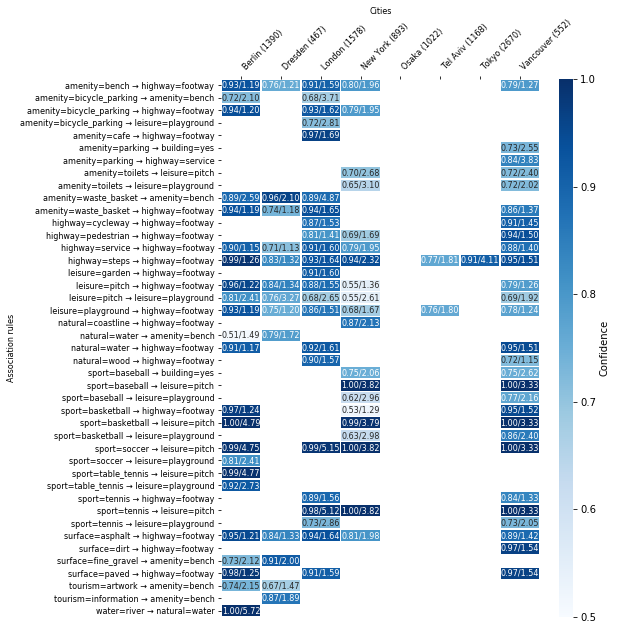

In [14]:
nbu.plot_rule_heatmap(heatmap_df_all, labels=labels_all, left=0.35, top=0.88, vmin=0.5, vmax=1, figsize=(8.5,9), fontsize=8)
plt.savefig(os.path.join(figures_dir, "figure_3.pdf"), dpi=600, layout="tight")

In [15]:
len(heatmap_df_all)

43

In [16]:
interesting_rules_all.loc[(interesting_rules_all["consequents"] == "highway=footway") & (interesting_rules_all["city"] == "tokyo"),:]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest,rule,city
25,highway=steps,highway=footway,0.086517,0.221348,0.078652,0.909091,4.10706,0.059501,8.565169,0.687743,highway=steps → highway=footway,tokyo


## 2. Context based Association Rules

### Association rules based on number of objects inside park

Select parks which fully or partly contain at least 3 objects.

In [17]:
features_nonempty = all_features.loc[(all_features["feature_count"] >= 3)]

In [18]:
rules_nonempty, labels_nonempty = nbu.generate_association_rules(features_nonempty, MAX_RULE_SIZE, 
                                                                  MIN_SUPPORT, city_labels)

dresden: 391 features
berlin: 1263 features
london: 1108 features
telaviv: 587 features
tokyo: 830 features
osaka: 312 features
newyork: 566 features
vancouver: 445 features


In [19]:
heatmap_df_nonempty, interesting_rules_nonempty = nbu.select_interesting_rules(rules_nonempty, 
                                                                               MIN_CONFIDENCE, MIN_LIFT)

In [20]:
# Filter for interesting rules based on minimum confidence and lift values over all cities
min_confidence_all_cities = 0.5
min_lift_all_cities = 1.1
heatmap_df_nonempty = heatmap_df_nonempty.loc[(heatmap_df_nonempty["lift"].min(axis=1) >= min_lift_all_cities) & 
                                              (heatmap_df_nonempty["confidence"].min(axis=1) >= min_confidence_all_cities) & 
                                              (heatmap_df_nonempty["confidence"].notna().sum(axis=1) >= 1)]

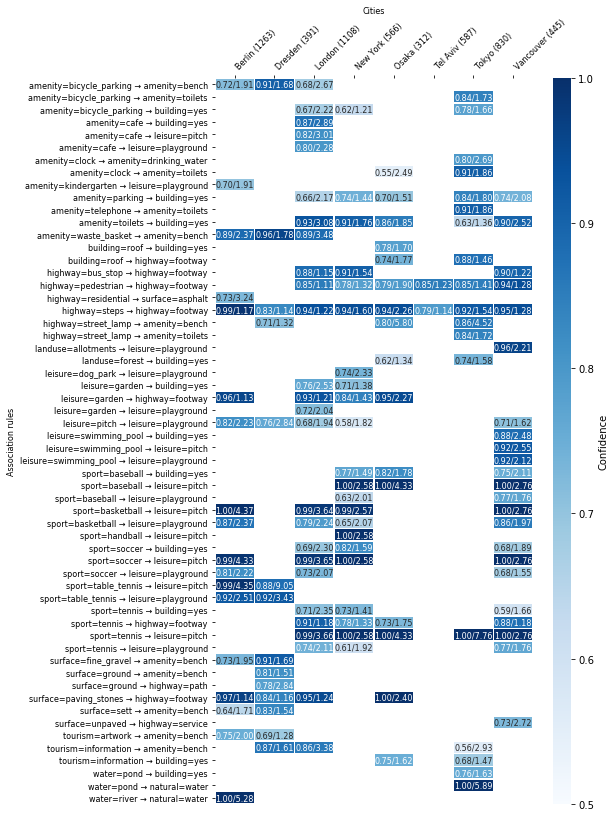

In [21]:
nbu.plot_rule_heatmap(heatmap_df_nonempty, figsize=(8.5,12), labels=labels_nonempty, vmin=0.5, vmax=1, left=0.35, top=0.89, fontsize=8)
plt.savefig(os.path.join(figures_dir, "figure_5.pdf"), dpi=600, layout="tight")

In [22]:
len(heatmap_df_nonempty)

58

### Association rules based on park size 

#### Large parks (> 5000 m2)

Select parks which are larger than 5000 m^2.

In [23]:
large_parks = all_features.loc[(all_features["area"] >= 5000)]

In [24]:
rules_large, labels_large = nbu.generate_association_rules(large_parks, MAX_RULE_SIZE, MIN_SUPPORT, city_labels)

dresden: 142 features
berlin: 695 features
london: 616 features
telaviv: 425 features
tokyo: 411 features
osaka: 278 features
newyork: 298 features
vancouver: 353 features


In [25]:
heatmap_df_large, interesting_rules_large = nbu.select_interesting_rules(rules_large, MIN_CONFIDENCE, MIN_LIFT)

In [26]:
min_confidence_all_cities = 0.5
min_lift_all_cities = 0.99
valid_in_cities = 4
heatmap_df_large = heatmap_df_large.loc[(heatmap_df_large["lift"].min(axis=1) >= min_lift_all_cities) & 
                            (heatmap_df_large["confidence"].min(axis=1) >= min_confidence_all_cities) & 
                            (heatmap_df_large["confidence"].notna().sum(axis=1) >= valid_in_cities)]

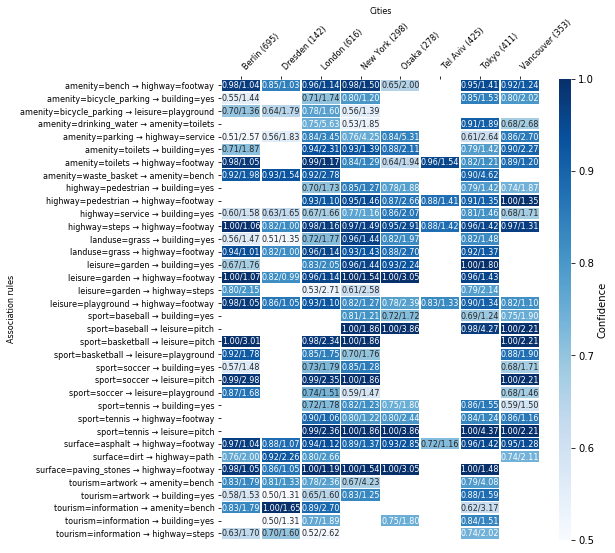

In [27]:
nbu.plot_rule_heatmap(heatmap_df_large, figsize=(8.5,8), labels=labels_large, vmin=0.5, vmax=1, left=0.35, top=0.85)
plt.savefig(os.path.join(figures_dir, "figure_6.pdf"), dpi=600, layout="tight")

In [28]:
len(heatmap_df_large)

36

#### Small parks

Select parks which are smaller than 5000 m^2 and contain at least 3 objects.

In [29]:
small_parks = all_features.loc[(all_features["area"] < 5000) & (all_features["feature_count"] >= 3)]

In [30]:
rules_small, labels_small = nbu.generate_association_rules(small_parks, MAX_RULE_SIZE, MIN_SUPPORT, city_labels)

dresden: 252 features
berlin: 575 features
london: 522 features
telaviv: 260 features
tokyo: 486 features
osaka: 133 features
newyork: 292 features
vancouver: 120 features


In [31]:
heatmap_df_small, interesting_rules_small = nbu.select_interesting_rules(rules_small, MIN_CONFIDENCE, MIN_LIFT)

In [32]:
min_confidence_all_cities = 0.5
min_lift_all_cities = 1
valid_in_cities = 0
heatmap_df_small = heatmap_df_small.loc[(heatmap_df_small["lift"].min(axis=1) >= min_lift_all_cities) & 
                            (heatmap_df_small["confidence"].min(axis=1) >= min_confidence_all_cities) & 
                            (heatmap_df_small["confidence"].notna().sum(axis=1) >= valid_in_cities)]


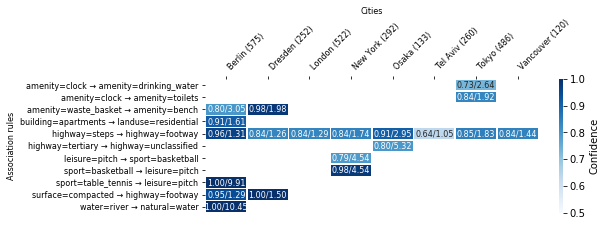

In [33]:
nbu.plot_rule_heatmap(heatmap_df_small, figsize=(8.5,3), labels=labels_small, vmin=0.5, vmax=1, left=0.32, top=0.67, fontsize=8)
plt.savefig(os.path.join(figures_dir, "figure_7.pdf"), dpi=600, layout="tight")

## 3. Association rules across different contexts and cities

Within the context-based association analysis, subsets of park features are selected based on different context variables (e.g. area, number of tags). For each subset, association rules are generated. Comparing the confidence and lift values of association rules derived from different subsets of parks indicates which much the context variables influence the generation of association rules.

__Warning: This analysis takes more than 20 minutes.__ Therefore, the precomputed results of this analysis have been stored in the _./interim_results_ folder. By default these precomputed results are loaded instead of running the analysis again. If you would like to run the analysis, set ```run_analysis=True```.

In [34]:
run_analysis = False

In [35]:
if not run_analysis:
    counts = pd.read_json(os.path.join(interim_dir, "counts.csv"), orient="table").T
    city_rules = city_rules2 = nbu.load_city_rules(cities, interim_dir, all_features)
else:
    counts, city_rules = nbu.context_association_rules_all_cities(all_features, MIN_FEATURES, MIN_SUPPORT, city_labels)
    with open(os.path.join(interim_dir, "counts.csv"), "w") as dst:
        counts = dst.write(counts.T.to_json(orient="table"))
    nbu.dump_city_rules(city_rules, interim_dir)

In [36]:
nbu.tab_4(counts, tables_dir)

,Dresden,Berlin,London,Tel Aviv,Tokyo,Osaka,New York,Vancouver
Number of tags,0/0 (7),\textbf{33/0 (1)},\textbf{34/2 (1)},0/0 (3),\textbf{24/0 (2)},\textbf{1/0 (2)},\textbf{13/5 (1)},0/0 (9)
Area,0/0 (7),\textbf{21/1 (2)},21/0 (3),\textbf{2/0 (1)},20/0 (3),\textbf{2/0 (1)},\textbf{9/0 (2)},0/0 (9)
Feature count,\textbf{1/0 (2)},\textbf{21/0 (2)},\textbf{27/0 (2)},0/0 (3),\textbf{28/1 (1)},0/0 (4),0/0 (9),1/0 (7)
Inner user count,\textbf{1/0 (2)},17/0 (4),20/2 (5),0/0 (3),7/0 (4),0/0 (4),5/0 (4),3/0 (4)
Outer user count,\textbf{2/0 (1)},7/2 (7),14/3 (7),0/1 (3),7/0 (4),0/0 (4),1/0 (6),3/0 (4)
Number of changes,0/0 (7),14/2 (5),16/1 (6),\textbf{2/0 (1)},6/0 (7),0/0 (4),\textbf{9/0 (2)},\textbf{4/1 (2)}
Version number,0/0 (7),14/1 (5),21/1 (3),0/0 (3),7/0 (4),\textbf{1/0 (2)},3/1 (5),1/0 (7)
Days since creation,\textbf{1/2 (2)},0/3 (12),8/0 (8),0/0 (3),4/0 (8),0/0 (4),1/0 (6),\textbf{4/0 (2)}
Random,\textbf{1/0 (2)},1/1 (10),1/0 (11),0/0 (3),0/0 (11),0/0 (4),1/1 (6),2/1 (6)
Building density,0/0 (7),1/3 (10),5/5 (9),0/0 (3),1/3 (9),0/0 (4),0/2 (9),\textbf{5/6 (1)}


### London: leisure=pitch -> amenity=bench (Figure 4)

In [37]:
heatmap_corr_df = city_rules["london"]["heatmap"]
all_valid_rules_df = city_rules["london"]["valid_rules"]
all_sel_features_df = city_rules["london"]["sel_features"]

leisure=pitch->amenity=bench


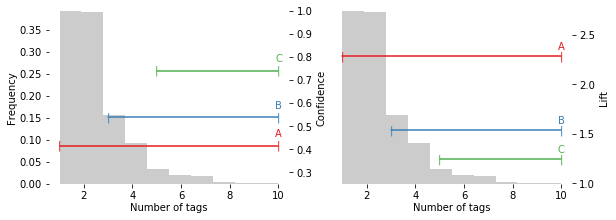

In [38]:
current_rule = heatmap_corr_df.index.values[40]
nbu.fig_4(current_rule, "n_tags", all_valid_rules_df, all_sel_features_df, figures_dir)

plot all rules of London

In [39]:
import seaborn as sns

Text(68.09374999999999, 0.5, 'Association rules')

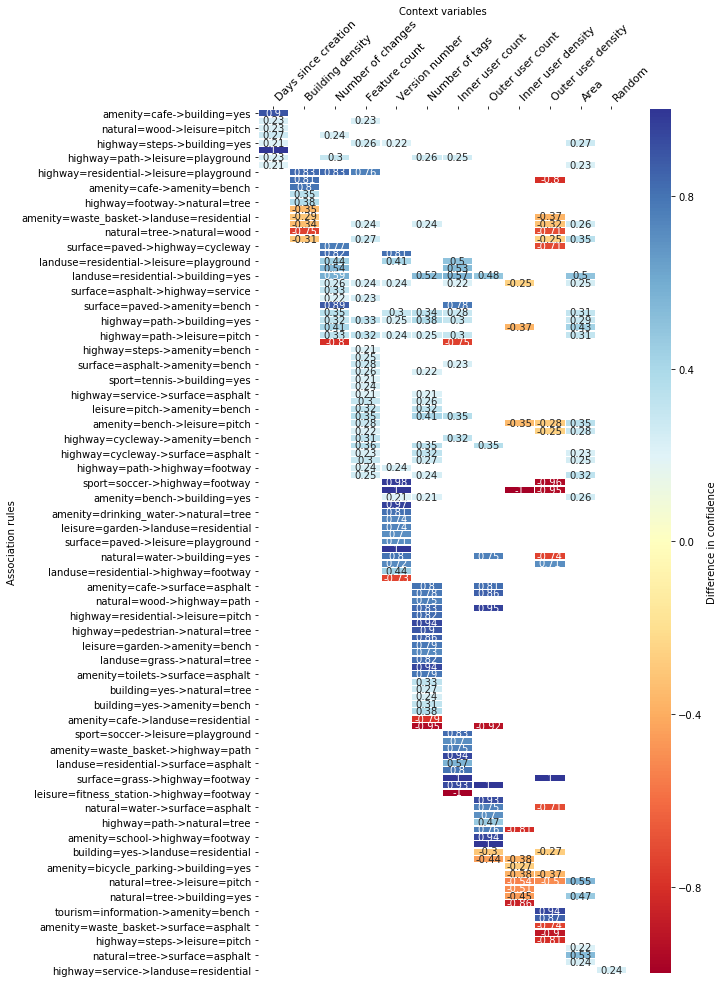

In [40]:
fig, ax =plt.subplots(figsize=(10, 15))
map = sns.heatmap(heatmap_corr_df, cmap="RdYlBu", ax=ax, linecolor="white", linewidths=-0.5, rasterized=True, center=0, vmin=-1, vmax=1, cbar_kws={'label': 'Difference in confidence', "aspect":40}, annot=True) #"RdYlBu"
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top') 
map.set_xticklabels(map.get_xticklabels(), rotation=45, horizontalalignment='left', fontsize=11)
map.set_yticklabels(map.get_yticklabels(), fontsize=10)
plt.gcf().subplots_adjust(left=0.36, right=1, top=0.85, bottom=0.05)
plt.xlabel('Context variables', fontsize=10)
plt.ylabel('Association rules', fontsize=10)
#plt.savefig(os.path.join(fig_dir, "heatmap_context_%s_%s.pdf" % (region, tag)), dpi=300, layout="tight")